In [ ]:
# TODO: Fix gradient descent with regularization

#### Libraries

In [2]:
from pathlib import Path
from random import shuffle

import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from IPython.display import clear_output

#### Data Loader

In [3]:
class DataLoader():
  def __init__(self, ds, batch_size):
    self.x = ds[0]
    self.y = ds[1]
    self.size = ds[0].shape[0]
    self.batch_size = batch_size

  def __iter__(self):
    rnd = [*range(self.size)]
    i = - self.batch_size
    shuffle(rnd)
    while i + self.batch_size < self.size:
      i += self.batch_size
      index = rnd[i:i + self.batch_size]
      yield self.x[index], self.y[index]

In [4]:
digits = load_digits()

x = digits.data / 16
y = np.zeros((digits.target.size, digits.target.max() + 1))
y[np.arange(digits.target.size), digits.target] = 1

x_train, x_test, y_train, y_test = train_test_split(
  x, y, test_size=.1)
x_train, x_valid, y_train, y_valid = train_test_split(
  x_train, y_train, test_size=.1)

train_dl = DataLoader((x_train, y_train), batch_size=4)
valid_dl = DataLoader((x_valid, y_valid), batch_size=4)
test_dl  = DataLoader((x_test , y_test),  batch_size=4)

#### Neural Network

In [5]:
class Dense():
  '''Dense layer.'''
  def __init__(self, output_size):
    self.input = None
    self.weight = None
    self.gradient = None
    self.input_size = None
    self.output_size = output_size

  def init_weight(self, input_size):
    '''Xavier et al. matrix initialization.'''
    self.input_size = input_size + 1
    shape = (self.input_size, self.output_size)
    std = np.sqrt(2 / (self.input_size + self.output_size))
    self.weight = np.random.normal(0, std, shape)

  def __call__(self, x, phase):
    self.input = x if phase == 'train' else None
    bias = np.ones((x.shape[0], 1))
    x = np.hstack((bias, x))
    return np.dot(x, self.weight)
  
  def backpropagate(self, error, lambd=10**-3):
    bias = np.mean(error, axis=0)
    self.gradient  = np.dot(self.input.T, error) / self.input.shape[0]
    self.gradient += self.weight[1:, :] * (lambd / self.input.shape[0])
    self.gradient = np.vstack((bias, self.gradient))
    return np.dot(error, self.weight[1:].T)

In [6]:
class Sigmoid():
  '''Sigmoid layer.'''
  def __init__(self):
    self.input = None

  def __call__(self, x, phase):
    self.input = x if phase == 'train' else None
    return 1 / (1 + np.exp(-x))

  def backpropagate(self, error, lambd=10**-3):
    z = self(self.input, 'valid')
    return error * (z * (1 - z))

In [7]:
class BinaryCrossEntropy():
  '''Binary cross entropy cost function.'''
  def __init__(self, lambd):
    self.lambd = lambd
  
  def __call__(self, y, yh, layers=[]):
    cost  = - y * np.log(yh + 10**-8)
    cost += - (1 - y) * np.log(1 - yh + 10**-8)
    cost = np.sum(cost) / y.shape[0]
    reg = 0
    for layer in layers:
      if hasattr(layer, 'weight'):
        reg += np.sum(layer.weight ** 2)
    reg = (self.lambd * reg) / (2 * y.shape[0])
    return cost + reg
  
  def accuracy(self, y, yh):
    y  = np.argmax(y , axis=1)
    yh = np.argmax(yh, axis=1)
    return np.mean(y == yh)
  
  def backpropagate(self, y, yh):
    return (yh - y) / (yh - yh * yh)

In [8]:
class GradientDescent():
  '''Gradient descent optimizer.'''
  def __init__(self, alpha=3*10**-1):
    self.alpha = alpha
  
  def step(self, layers):
    for layer in layers:
      if hasattr(layer, 'weight'):
        layer.weight -= self.alpha * layer.gradient

In [9]:
class NeuralNetwork():
  '''Neural network.'''
  def __init__(self, input_size, layers):
    self.layers = layers
    for layer in self.layers:
      if hasattr(layer, 'weight'):
        layer.init_weight(input_size)
        input_size = layer.output_size

  def predict(self, x, phase='valid'):
    for layer in self.layers:
      x = layer(x, phase)
    return x
  
  def backpropagate(self, error, lambd=10**-3):
    for layer in self.layers[::-1]:
      error = layer.backpropagate(error, lambd=lambd)
  
  def train(self, train_dl, cost_fun, optimizer, 
            valid_dl=None, epochs=20, verbose=True):
    history = {}
    acc, cost = self.test(train_dl, cost_fun, verbose=False)
    history['train_acc']  = [acc]
    history['train_cost'] = [cost]
    acc, cost = self.test(valid_dl, cost_fun, verbose=False)
    history['valid_acc']  = [acc]
    history['valid_cost'] = [cost]
    for epoch in range(epochs):
      if verbose:
        print(f'epoch {epoch + 1}')
        print(f'lambda {cost_fun.lambd}')
      for phase, dataloader in [('train', train_dl), ('valid', valid_dl)]:
        if not dataloader:
          continue
        acc = 0
        cost = 0
        for x, y in dataloader:
          yh = self.predict(x, phase=phase)
          acc  += cost_fun.accuracy(y, yh) * dataloader.batch_size
          cost += cost_fun(y, yh) * dataloader.batch_size       
          if phase == 'train':
            error = cost_fun.backpropagate(y, yh)
            self.backpropagate(error, lambd=cost_fun.lambd)
            optimizer.step(self.layers)
        acc  = acc / dataloader.size
        cost = cost / dataloader.size
        history[f'{phase}_acc'].append(acc)
        history[f'{phase}_cost'].append(cost)
        if verbose:
          print(f'{phase}_acc : {acc:.3f}')
          print(f'{phase}_cost: {cost:.3f}')
      if verbose:
        clear_output(wait=True)
    return history
  
  def test(self, dataloader, cost_fun, verbose=True):
    acc = 0
    cost = 0
    for x, y in dataloader:
      yh = self.predict(x)
      acc  += cost_fun.accuracy(y, yh) * dataloader.batch_size
      cost += cost_fun(y, yh) * dataloader.batch_size
    acc = acc / dataloader.size
    cost = cost / dataloader.size
    if verbose:
      print(f'test_acc: {acc:5.3f}')
      print(f'test_cost: {cost:.3f}')
    return acc, cost

In [10]:
nn = NeuralNetwork(64, 
                   [Dense(25), 
                    Sigmoid(), 
                    Dense(10), 
                    Sigmoid()])

history = nn.train(train_dl, 
                   BinaryCrossEntropy(lambd=0), 
                   GradientDescent(alpha=3*10**-3), 
                   valid_dl,
                   epochs=42)

epoch 42
lambda 0
train_acc : 0.832
train_cost: 2.049
valid_acc : 0.864
valid_cost: 2.046


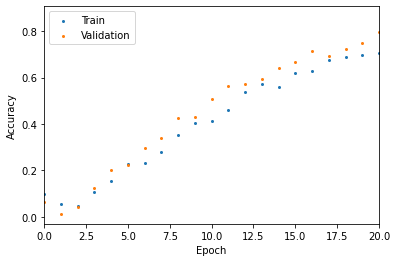

In [11]:
fig, ax = plt.subplots()
ax.scatter(range(43), history['train_acc'], s=4, label='Train')
ax.scatter(range(43), history['valid_acc'], s=4, label='Validation')
ax.legend()
plt.xlim(0, 20)
plt.xlabel('Epoch')
plt.ylabel('Accuracy');

In [12]:
nn.test(test_dl, BinaryCrossEntropy(lambd=0));

test_acc: 0.872
test_cost: 2.002


##### Gradient Checking


In [13]:
class NNDebugger():
  def __init__(self, nn):
    self.nn = nn

  def get_weights(self):
    weights = np.array([])
    for layer in self.nn.layers:
      if hasattr(layer, 'weight'):
        new_weight = layer.weight.flatten()
        weights = np.hstack((weights, new_weight))
    return weights

  def set_weights(self, weights):
    for layer in self.nn.layers:
      if hasattr(layer, 'weight'):
        size = layer.weight.size
        shape = layer.weight.shape
        layer.weight = weights[:size].reshape(shape)
        weights = weights[size:]

  def get_grads(self):
    grads = np.array([])
    for layer in self.nn.layers:
      if hasattr(layer, 'gradient') and np.all(layer.gradient):
        new_grad = layer.gradient.flatten()
        grads = np.hstack((grads, new_grad))
    return grads
  
  def check_gradient(self, x, y, cost_fun, epsilon=10**-4):
    yh = self.nn.predict(x, 'train')
    error = cost_fun.backpropagate(y, yh)
    self.nn.backpropagate(error, lambd=cost_fun.lambd)
    weights = self.get_weights()
    pertb = np.zeros_like(weights)
    grads = self.get_grads()
    num_grads = np.zeros_like(grads)
    for i in range(weights.size):
      pertb[i] = epsilon
      self.set_weights(weights + pertb)
      cost0 = cost_fun(y, self.nn.predict(x, 'valid'))
      self.set_weights(weights - pertb)
      cost1 = cost_fun(y, self.nn.predict(x, 'valid'))
      num_grads[i] = (cost0 - cost1) / (2 * epsilon)
      pertb[i] = 0
    return grads, num_grads

  def optimize(self, dataloader, cost_fun, filename):
    def cost(weights):
      print(weights[0])
      clear_output(wait=False)
      self.set_weights(weights)
      return self.nn.test(dataloader, cost_fun, False)[1]
    res = minimize(cost, 
                   self.get_weights(), 
                   method='CG',
                   options={
                       'maxiter': 20, 
                       'disp': True, 
                       'return_all': True})
    np.savez_compressed(f'./{filename}', dict(res))

In [14]:
for lambd in [0, 10**-3]:
  debugger = NNDebugger(NeuralNetwork(3, 
                                      [Dense(5), 
                                      Sigmoid(), 
                                      Dense(3), 
                                      Sigmoid()]))
  grads, num_grads = debugger.check_gradient(np.random.rand(3, 3), 
                                            np.eye(3), 
                                            BinaryCrossEntropy(lambd=lambd))

  print(f'Gradient checking with regularization {lambd}')
  print('Difference from numerical approximation:')
  print(grads - num_grads)
  print('Difference nome from numerical approximation:')
  print(np.linalg.norm(grads - num_grads), '\n')

Gradient checking with regularization 0
Difference from numerical approximation:
[ 3.44855096e-09  6.43872011e-10  4.03334342e-09  4.94660053e-10
 -2.74771293e-09  1.85070308e-09  2.94211931e-10  2.02623038e-09
  2.12613453e-10 -1.51683433e-09  2.23054553e-09  4.03126891e-10
  2.64913603e-09  3.22561672e-10 -1.76756687e-09  1.91378347e-09
  1.23580596e-10  2.39745757e-09  1.02989099e-10 -1.55329413e-09
 -8.30653568e-09  5.63261479e-09  1.90351483e-08 -5.11282183e-09
  3.21201882e-09  1.15260878e-08 -2.63814784e-09  1.95621648e-09
  6.86175028e-09 -3.75076219e-09  2.35417258e-09  8.26498178e-09
 -1.81879860e-09  1.07876693e-09  3.16489224e-09 -3.36621698e-09
  2.24619838e-09  7.11642775e-09]
Difference nome from numerical approximation:
3.0548903841144933e-08 

Gradient checking with regularization 0.001
Difference from numerical approximation:
[ 1.76671381e-09 -3.61598302e-10  1.17622549e-09  8.69600994e-09
  5.02175719e-09 -2.81236382e-04  1.39603165e-04  1.40804536e-04
 -9.31306640e-

#### References

[1] LeCun, Y., 1998. The MNIST database of handwritten digits. http://yann.lecun.com/exdb/mnist/.

[2] Nielsen, M.A., 2015. Neural networks and deep learning (Vol. 2018). San Francisco, CA: Determination press.

[3] Ng, A., 2017. Machine learning course. Coursera [online]. Available at: https://www.coursera.org/learn/machinelearning.